In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 219 (delta 123), reused 168 (delta 85), pack-reused 0
Receiving objects: 100% (219/219), 2.68 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
from cxlayers import ImageToElectricField, CxMO, AngularSpectrum, CxD2NNIntensity, D2NNMNISTDetector, ImageResizing, D2NNMNISTFilter, CxD2NNFaradayRotation, GGG, ImageBinarization, Polarizer
import os
# import matplotlib_style
import glob

tf.experimental.numpy.experimental_enable_numpy_behavior()
print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

In [3]:
path = 'trained_model/20220414_6'
model = tf.keras.models.load_model(path)
model.summary()

Metal device set to: Apple M1


2022-04-15 10:44:01.170815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-15 10:44:01.171091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing (ImageResizi  (None, 100, 100)         0         
 ng)                                                             
                                                                 
 image_binarization (ImageBi  (None, 100, 100)         0         
 narization)                                                     
                                                                 
 image_to_electric_field (Im  (None, 2, 2, 100, 100)   0         
 ageToElectricField)                                             
                                                                 
 cx_mo (CxMO)                (None, 2, 2, 100, 100)    10002     
                                                             

## 正解率

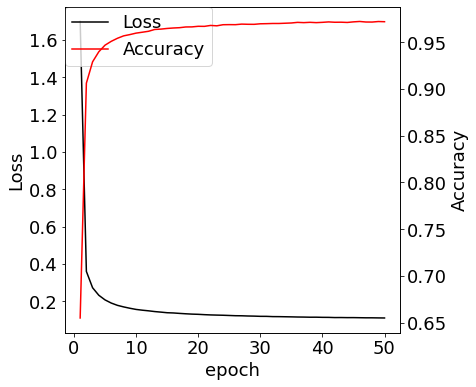

In [4]:
history = pd.read_csv(path + '/history.csv')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, history.index.stop + 1), history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, history.index.stop + 1), history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

# model.evaluate(x_test, y_test)

## 混同行列

In [9]:
pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
cm = tf.math.confusion_matrix(y_test, pred_label)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')

KeyboardInterrupt: 

## 位相変調層

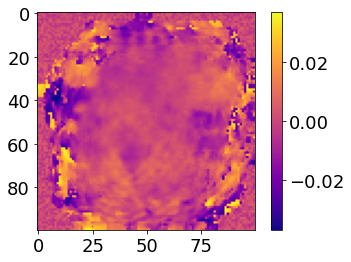

In [6]:
plt.imshow(2.1 * np.pi / 180* tf.sin(model.layers[4].get_weights()[0]), cmap='plasma')
plt.colorbar()

## 出力プロット

2022-04-15 10:44:54.845647: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-15 10:44:55.048575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 10:44:55.947211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 10:44:56.609862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


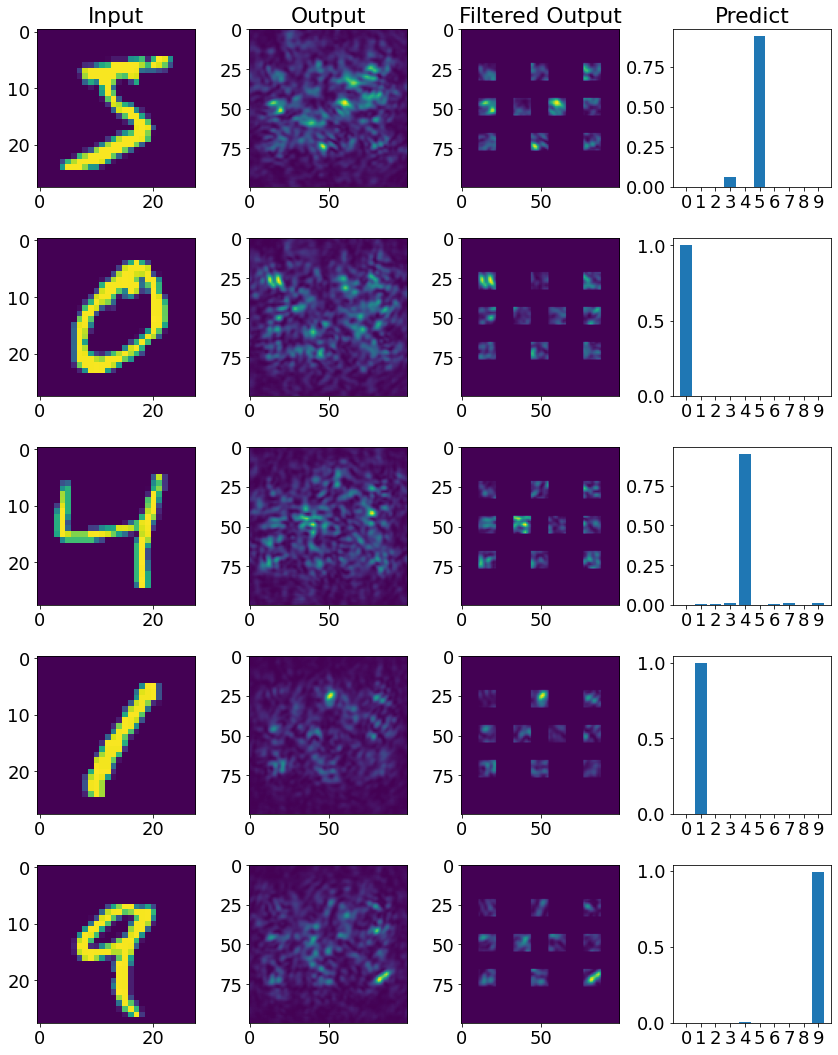

In [7]:
layer_name = model.layers[-3].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num + 0, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output")
        axes[i, 2].set_title("Filtered Output")
        axes[i, 3].set_title("Predict")
        
fig.tight_layout()

## 2値化して出力プロット

2022-03-30 12:38:52.544456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-30 12:38:52.823491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-30 12:38:53.068004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


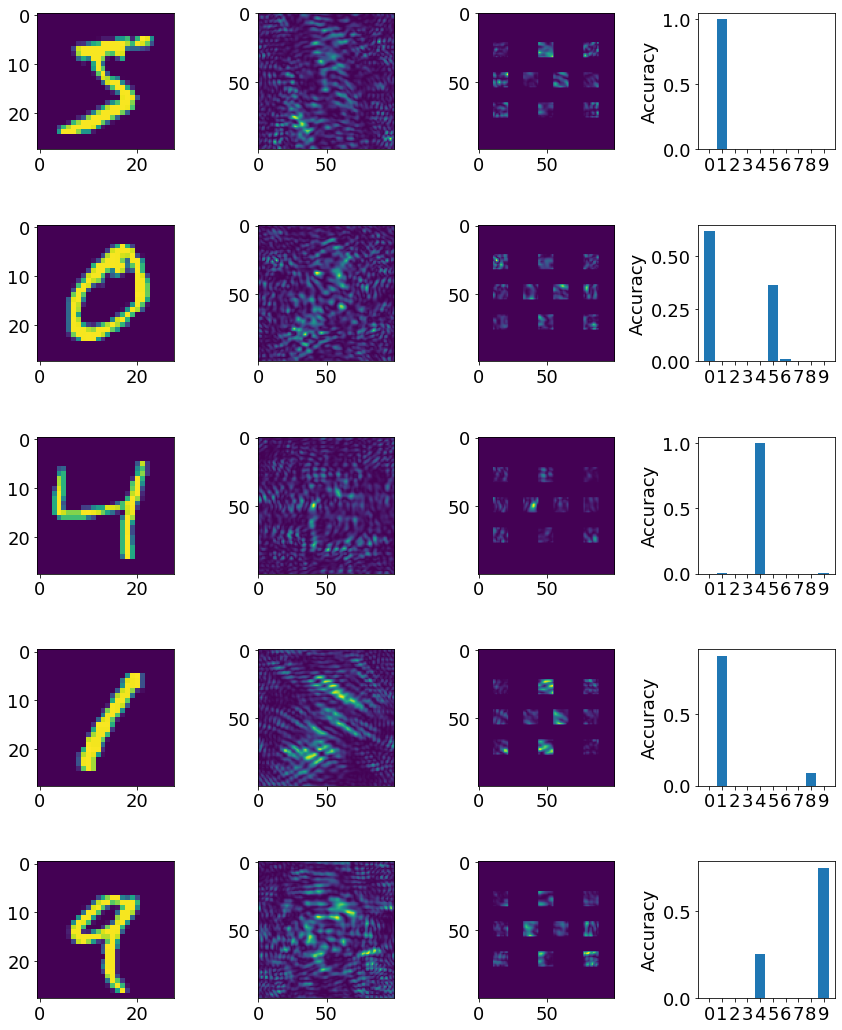

In [8]:
mo_layer_index = [4, 6]
limit_value = 2.1 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None

layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

In [9]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 111s 354ms/step - loss: 1.9323 - accuracy: 0.5802


[1.9323190450668335, 0.5802000164985657]

## 位相変調量

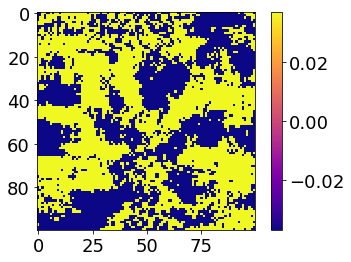

In [16]:
bi_phase = model.layers[5].get_weights()[0]
plt.imshow(bi_phase, cmap='plasma', interpolation='none')
plt.colorbar()
bi_phase = np.where(bi_phase >= 0, 1, -1)
np.savetxt('data/phase/20220319-1/layer2.csv', bi_phase, fmt='%d', delimiter=',')

## 学習過程の正解率比較

Text(0.5, 0, 'epoch')

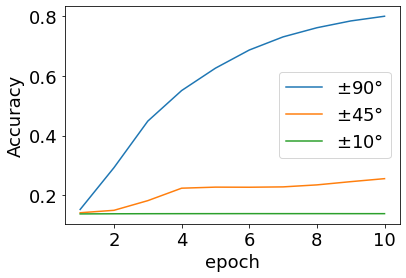

In [17]:
path = 'trained_model'
files = glob.glob(path + '/20220317*/history.csv')
labels = [r'$\pm 90\degree$', r'$\pm 45 \degree$', r'$\pm 10 \degree$']
for i, file in enumerate(files):
    history = pd.read_csv(file)
    plt.plot(range(1, history.index.stop + 1), history['accuracy'], label=labels[i])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("epoch")

## 3値化

In [ ]:
mo_layer_index = [3]
sep = 90 * np.pi / 180
limit_value = 90 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None

In [8]:
model.get_weights()[2]

array([-1.5701561], dtype=float32)

In [60]:
shape = (100, 100)
inputs = tf.keras.layers.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0, 1)(x)
x = ImageToElectricField(shape)(x)
x = CxMO(shape)(x)
x = AngularSpectrum(shape, 531e-9, 0.5e-3, 2.0e-6, n=1, normalization='max', method='expand')(x)
x = CxMO(shape)(x)
x = AngularSpectrum(shape, 531e-9, 2.0e-3, 2.0e-6, n=1, normalization='max', method='expand')(x)
x = Polarizer(shape, phi=-np.pi/2, trainable=True)(x)
x = CxD2NNIntensity(shape)(x)
x = D2NNMNISTDetector(10, activation='softmax')(x)

testmodel = tf.keras.Model(inputs, x)
testmodel.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])
testmodel.layers[4].set_weights(2.1*np.pi/180*tf.tanh(model.layers[4].get_weights()))

In [61]:
testmodel.layers[6].set_weights(2.1*np.pi/180*tf.tanh(model.layers[6].get_weights()))

In [62]:
testmodel.layers[-3].phi

<tf.Variable 'phi:0' shape=(1,) dtype=float32, numpy=array([-1.5707964], dtype=float32)>

In [63]:
testmodel.evaluate(x_test, y_test)

2022-04-05 01:04:20.593615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 18/313 [>.............................] - ETA: 6:52 - loss: 2.3020 - accuracy: 0.7396

KeyboardInterrupt: 

# 複数モデル比較

## 学習経過

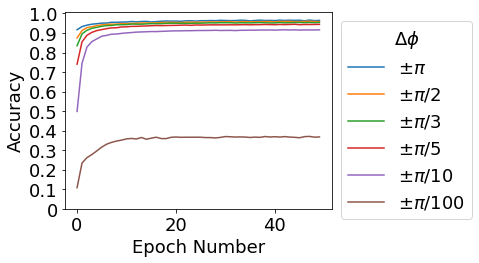

In [3]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220415_*/*.csv"
files = glob.glob(path)
files.sort(reverse=True)
plt.figure(figsize=(7, 4))
lines = []
for i, file in enumerate(files):
    result = pd.read_csv(file)
    lines.append(plt.plot(result["val_accuracy"], label=label[i]))

plt.legend(title=r'$\Delta \phi$', loc='upper left', bbox_to_anchor=(1, 1))
plt.yticks(np.arange(0, 1.1, 0.1), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel("Accuracy")
plt.xlabel("Epoch Number")
plt.tight_layout()

## 出力

2022-04-12 11:18:49.708386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:49.917799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:50.144720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:50.749098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:50.961645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:51.172517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 11:18:51.766477: I tensorflow/core/grappler/optimizers/cust

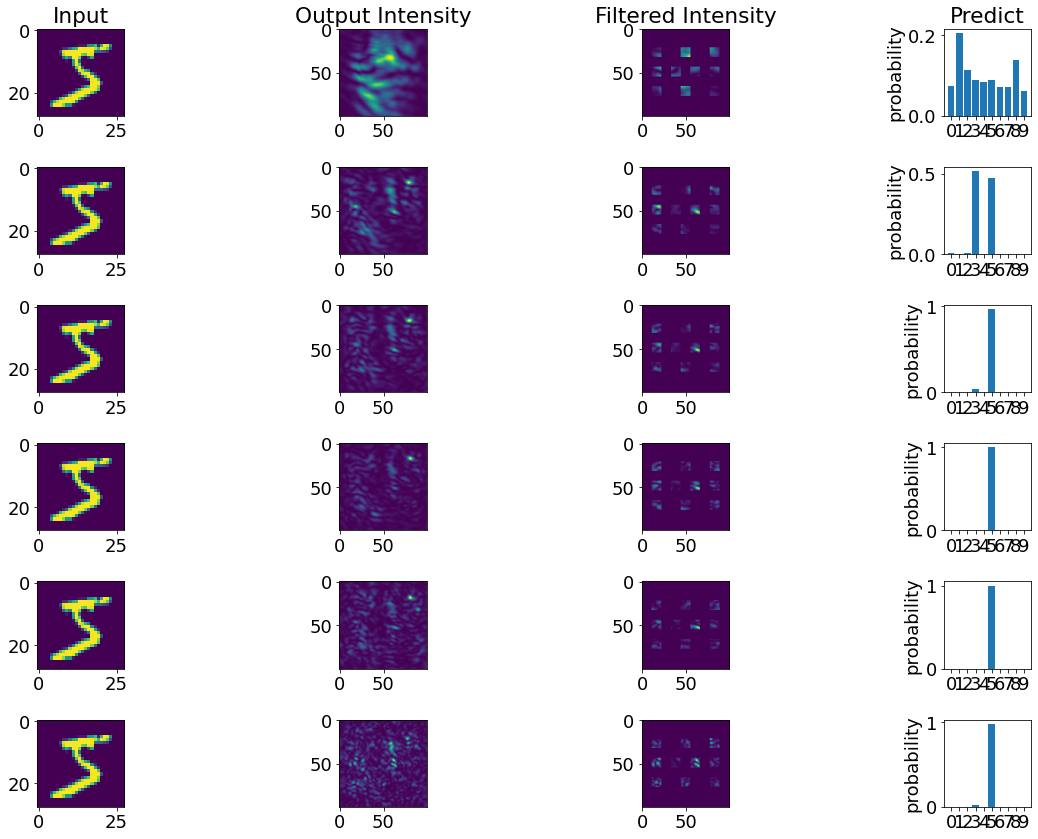

In [17]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220410_*"
files = glob.glob(path)
files.sort()

input_images = x_train[0:2,:,:]
fig, axes = plt.subplots(len(files), 4, figsize=(len(files)*3, 4*3))
for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    output_layer_name = model.layers[-3].name
    output_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(output_layer_name).output)
    filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(output_layer_name).output)
    filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

    output_images = output_layer_model.predict(input_images)
    filtered_images = filter_model.predict(input_images)
    pred = model.predict(input_images)

    axes[i, 0].imshow(images[0, :, :])
    axes[i, 1].imshow(output_images[0, :, :])
    axes[i, 2].imshow(filtered_images[0,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), pred[0, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Output Intensity")
        axes[i, 2].set_title("Filtered Intensity")
        axes[i, 3].set_title("Predict")

fig.tight_layout()

In [8]:
label = [r'$\pm \pi$',r'$\pm \pi/2$', r'$\pm \pi/3$',r'$\pm \pi/5$',r'$\pm \pi/10$', r'$\pm \pi/100$']
path = "trained_model/20220415_*"
files = glob.glob(path)
files.sort()
print(files)

for i, file in enumerate(files):
    model = tf.keras.models.load_model(file)
    print(model.layers[-4].get_weights()[0] * 180 / np.pi)

fig.tight_layout()

['trained_model/20220415_1', 'trained_model/20220415_2', 'trained_model/20220415_3', 'trained_model/20220415_4', 'trained_model/20220415_5', 'trained_model/20220415_6']
Metal device set to: Apple M1


2022-04-18 15:11:31.551374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 15:11:31.551632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


80.64450115301494
79.81873811254957
70.09541741390282
63.01641128261567
58.06893643656026
50.4132881695002


NameError: name 'fig' is not defined